In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

# GSoC 2019: Introduction of pymc3.ode API
by [Demetri Pananos](https://dpananos.github.io/posts/2019/08/blog-post-21/)

Ordinary differential equations (ODEs) are a convenient mathematical framework for modelling the temporal dynamics of a system in disciplines from engineering to ecology. Though most analyses focus on bifurcations and stability of fixed points, parameter and uncertainty estimates are more salient in systems of practical interest, such as population pharmacokinetics and pharmacodynamics.


Both parameter estimation and uncertainty propagation are handled elegantly by the Bayesian framework.  In this notebook, I showcase how PyMC3 can be used to do inference for differential equations using the `ode` submodule. While the current implementation is quite flexible and well integrated, more complex models can easily become slow to estimate. A new package that integrates the much faster `sundials` package into PyMC3 called `sunode` can be found [here](https://github.com/aseyboldt/sunode). 


## Catching Up On Differential Equations

A differential equation is an equation relating an unknown function's derivative to itself.  We usually write differentual equations as 

$$ \mathbf{y}' = f(\mathbf{y},t,\mathbf{p}) \quad \mathbf{y}(t_0) = \mathbf{y}_0 $$

Here, $\mathbf{y}$ is the unknown function, $t$ is time, and $\mathbf{p}$ is a vector of parameters.  The function $f$ can be either scalar or vector valued.

Only a small subset of differential equations have an analytical solution.  For most differential equations of applied interest, numerical methods must be used to obtain approximate solutions.


## Doing Bayesian Inference With Differential Equations

PyMC3 uses Hamiltonian Monte Carlo (HMC) to obtain samples from the posterior distribution.  HMC requires derivatives of the ODE's solution with respect to the parameters $p$.  The `ode` submodual automatically computes appropriate derivatives so you don't have to.  All you have to do is 

* Write the differential equation as a python function
* Write the model in PyMC3
* Hit the Inference Button $^{\text{TM}}$

Let's see how this is done in practice with a small example.

## A Differential Equation For Freefall

An object of mass $m$ is brought to some height and allowed to fall freely until it reaches the ground. A differential equation describing the object's speed over time is 

$$ y' = mg - \gamma y $$

The force the object experiences in the downwards direction is $mg$, while the force the object experiences in the opposite direction (due to air resistance) is proportional to how fast the object is presently moving. Let's assume the object starts from rest (that is, that the object's inital velocity is 0).  This may or may not be the case.  To showcase how to do inference on intial conditions, I will first assume the object starts from rest, and then relax that assumption later.

Data on this object's speed as a function of time is shown below.  The data may be noisy because of our measurement tools, or because the object is an irregular shape, thus leading to times during freefall when the object is more/less aerodynamic.  Let's use this data to estimate the proportionality constant for air resistance.

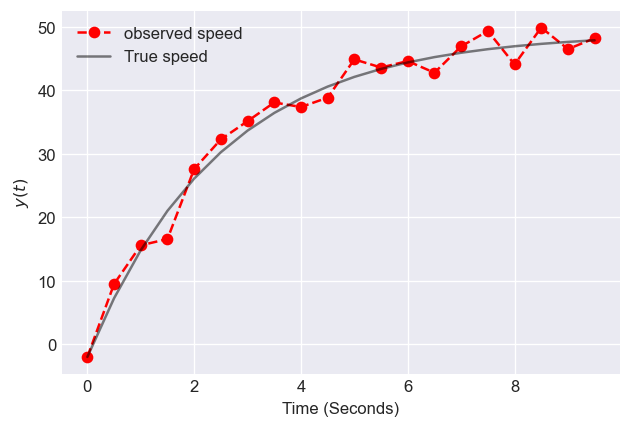

In [2]:
# For reproducibility
np.random.seed(20394)

def freefall(y, t, p):    
    return 2.0 * p[1] - p[0] * y[0]

# Times for observation
times = np.arange(0,10,0.5)
gamma, g, y0, sigma = 0.4, 9.8, -2, 2
y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma, g]]))
yobs = np.random.normal(y,2)

fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True speed', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$');
plt.show()

To specify and ordinary differential equation with pyMC3, use the `DifferentialEquation` class.  This class takes as arguments:

* `func`: A function specifying the differential equation (i.e. $f(\mathbf{y},t,\mathbf{p})$).
* `times`: An array of times at which data was observed.
* `n_states`: The dimension of $f(\mathbf{y},t,\mathbf{p})$.
* `n_theta`: The dimension of $\mathbf{p}$.
* `t0`: Optional time to which the initial condition belongs.

The argument `func` needs to be written as if `y` and `p` are vectors.  So even when your model has one state and/or one parameter, you should explicitly write `y[0]` and/or `p[0]`.

Once the model is specified, we can use it in our pyMC3 model by passing parameters and inital conditions.  `DifferentialEquation` returns a flattened solution, so you will need to reshape it to the same shape as your observed data in the model.

Shown below is a model to estimate $\gamma$ in the ODE above.

In [3]:
ode_model = DifferentialEquation(
    func=freefall,
    times=times,
    n_states=1, 
    n_theta=2,
    t0=0
)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    sigma = pm.HalfCauchy('sigma', 1)    
    gamma = pm.Lognormal('gamma',0, 1)
    
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])
    # The ode_solution has a shape of (n_times, n_states)
    
    Y = pm.Normal('Y', mu=ode_solution, sigma=sigma, observed=yobs)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 493 seconds.


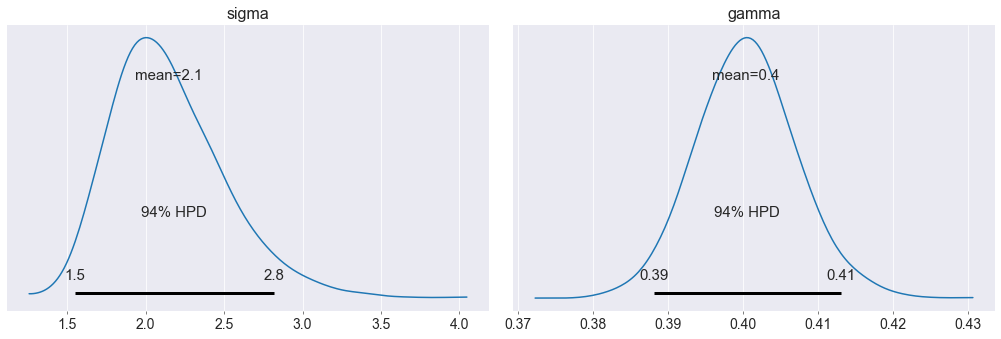

In [4]:
az.plot_posterior(data);

Our estimates of the proportionality constant and noise in the system are incredibly close to their actual values!

We can even estimate the acceleration due to gravity by specifying a prior for it.

In [5]:
with pm.Model() as model2:    
    sigma = pm.HalfCauchy('sigma',1)
    gamma = pm.Lognormal('gamma',0,1)
    # A prior on the acceleration due to gravity
    g = pm.Lognormal('g',pm.math.log(10),2)
    
    # Notice now I have passed g to the odeparams argument
    ode_solution = ode_model(y0=[0], theta=[gamma, g])
    
    Y = pm.Normal('Y', mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [g, gamma, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2202 seconds.


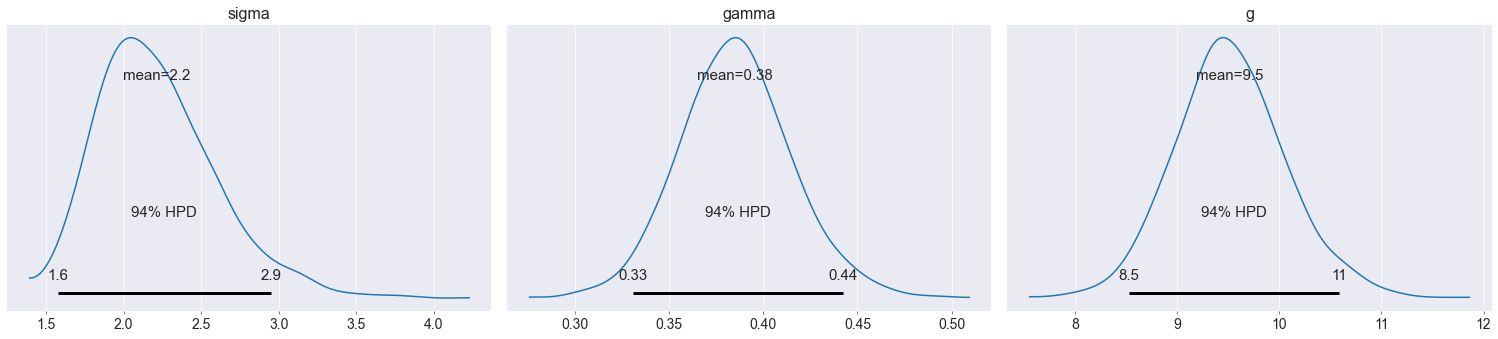

In [6]:
az.plot_posterior(data);

The uncertainty in the acceleration due to gravity has increased our uncertainty in the proportionality constant.

Finally, we can do inference on the initial condition.  If this object was brought to its initial height by an airplane, then turbulent air might have made the airplane move up or down, thereby changing the inital velocity of the object. 

Doing inference on the initial condition is as easy as specifying a prior for the inital condition, and then passing the inital condition to `ode_model`.

In [7]:
with pm.Model() as model3:    
    sigma = pm.HalfCauchy('sigma', 1)
    gamma = pm.Lognormal('gamma', 0, 1)
    g = pm.Lognormal('g', pm.math.log(10), 2)
    # Initial condition prior.  We think it is at rest, but will allow for perturbations in initial velocity.
    y0 = pm.Normal('y0', 0, 2)
    
    ode_solution = ode_model(y0=[y0], theta=[gamma, g])
    
    Y = pm.Normal('Y', mu=ode_solution, sigma=sigma, observed=yobs)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [y0, g, gamma, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2165 seconds.


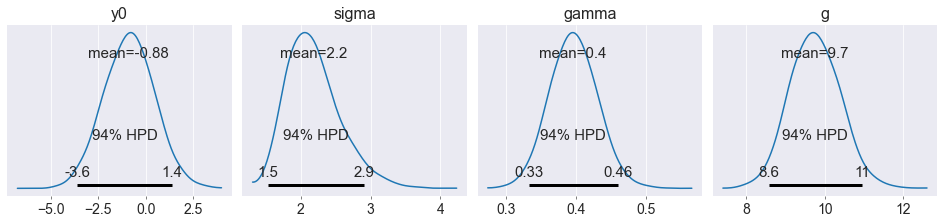

In [8]:
az.plot_posterior(data, figsize=(13,3));

Note that by explicitly modelling the initial condition, we obtain a much better estimate of the acceleration due to gravity than if we had insisted that the object started at rest.

## Non-linear Differential Equations

The example of an object in free fall might not be the most appropriate since that differential equation can be solved exactly. Thus, `DifferentialEquation` is not needed to solve that particular problem.  There are, however, many examples of differential equations which cannot be solved exactly.  Inference for these models is where `DifferentialEquation` truly shines.

Consider the SIR model of infection.  This model describes the temporal dynamics of a disease spreading through a homogenously mixed closed population.  Members of the population are placed into one of three cateories: Susceptible, Infective, or Recovered.  The differential equations are...


$$ \dfrac{dS}{dt} = - \beta SI \quad S(0) = S_0 $$
$$ \dfrac{dI}{dt} = \beta SI - \lambda I \quad I(0) = I_0 $$
$$ \dfrac{dR}{dt} = \lambda I \quad R(0) = R_0 $$

With the constraint that $S(t) + I(t) + R(t) = 1 \, \forall t$. Here, $\beta$ is the  rate  of infection per susceptible and per infective, and $\lambda$ is the rate of recovery.

If we knew $S(t)$ and $I(t)$, then we could determine $R(t)$, so we can peel off the differential equation for $R(t)$ and work only with the first two.  


In the SIR model, it is straight-forward to see that $\beta, \gamma$ and $\beta/2, \gamma/2$ will produce the same qualitative dynamics but on much different time scales.  To study the *quality* of the dynamics, regardless of time scale, applied mathematicians will *non-dimensionalize* differential equations.  Non-dimensionalization is the process of introducing scaleless variables into the differential equation to understand the system's dynamics under families of equivalent paramterizations.

To non-dimensionalize this system, let's scale time by $1/\lambda$ (we do this because people stay infected for an average of $1/\lambda$ units of time.  It is a straight forward argument to show this.  For more, see [1]).  Let $t = \tau/\lambda$, where $\tau$ is a unitless variable.  Then...


$$ \dfrac{dS}{d\tau} = \dfrac{dt}{d\tau} \dfrac{dS}{dt} = \dfrac{1}{\lambda}\dfrac{dS}{dt} = -\dfrac{\beta}{\lambda}SI$$

and 

$$ \dfrac{dI}{d\tau} = \dfrac{dt}{d\tau} \dfrac{dI}{dt} = \dfrac{1}{\lambda}\dfrac{dI}{dt} = \dfrac{\beta}{\lambda}SI - I$$

The quantity $\beta/\lambda$ has a very special name.  We call it *The R-Nought* ($\mathcal{R}_0$).  It's interpretation is that if we were to drop a single infected person into a population of suceptible individuals, we would expect $\mathcal{R}_0$ new infections.  If $\mathcal{R}_0>1$, then an epidemic will take place.  If $\mathcal{R}_0\leq1$ then there will be no epidemic (note, we can show this more rigoursly by studying eigenvalues of the system's Jacobain.  For more, see [2]).

This non-dimensionalization is important because it gives us information about the parameters.  If we see an epidemic has occured, then we know that $\mathcal{R}_0>1$ which means $\beta> \lambda$. Furthermore, it might be hard to place a prior on $\beta$ because of beta's interpretation.  But since $1/\lambda$ has a simple interpretation, and since $\mathcal{R}_0>1$, we can obtain $\beta$ by computing $\mathcal{R}_0\lambda$. 

Side note: I'm going to choose a likelihood which certainly violates these constraints, just for exposition on how to use `DifferentialEquation`.  In reality, a likelihood which respects these constraints should be chosen.


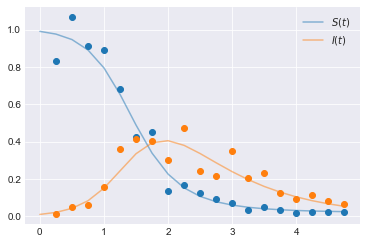

In [9]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]    
    return [ds, di]

times = np.arange(0, 5, 0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [14]:
sir_model = DifferentialEquation(
    func=SIR, 
    times=np.arange(0.25, 5, 0.25), 
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:    
    sigma = pm.HalfCauchy('sigma', 1, shape=2)
    
    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    lam = pm.Lognormal('lambda', pm.math.log(2), 2)
    beta = pm.Deterministic('beta', lam * R0)
    
    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])
    
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)    
    data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda, R0, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3774 seconds.


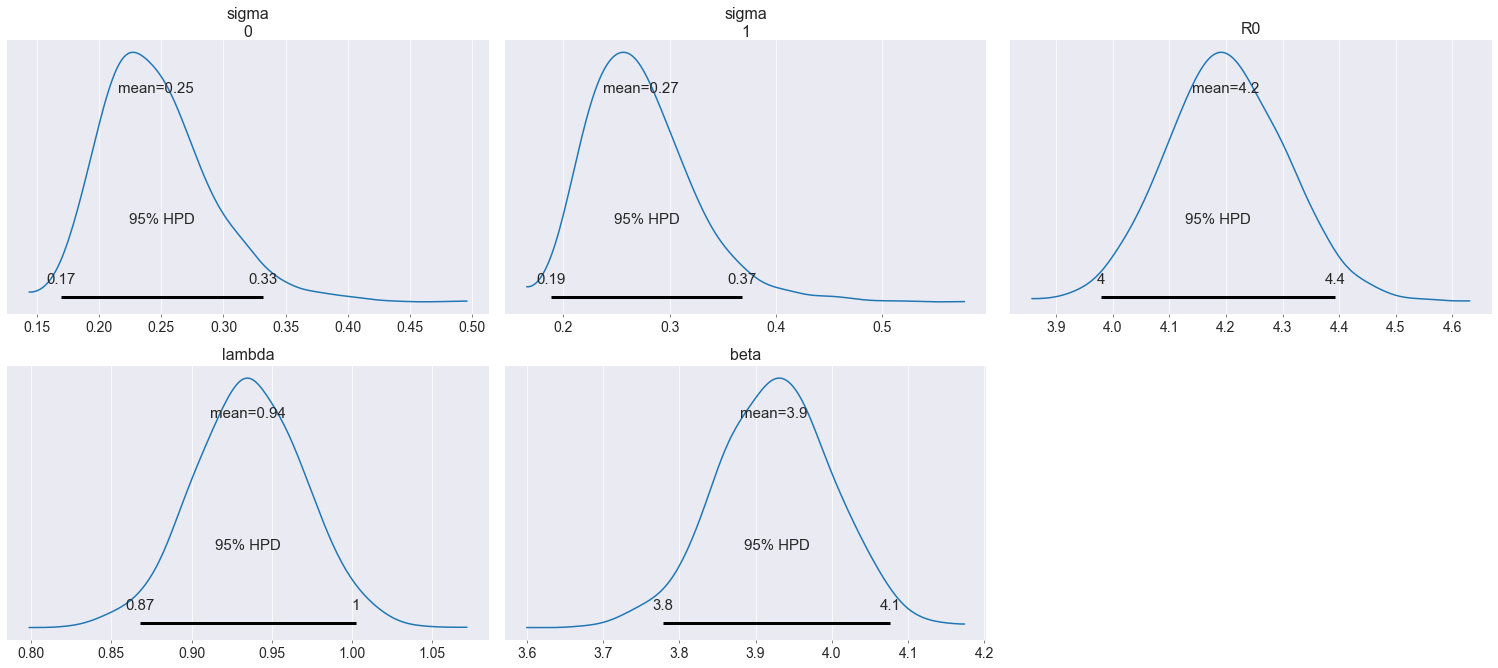

In [15]:
az.plot_posterior(data, round_to=2, credible_interval=0.95, compact=True);

As can be seen from the posterior plots, $\beta$ is well estimated by leveraging knoweldege about the non-dimensional parameter $\mathcal{R}_0$ and $\lambda$.

## Conclusions & Final Thoughts

ODEs are a really good model for continuous temporal evolution.  With the addition of `DifferentialEquation` to PyMC3, we can now use bayesian methods to estimate the parameters of ODEs.

`DifferentialEquation` is not as fast as compared to Stan's `integrate_ode_bdf`.  However, the ease of use of `DifferentialEquation` will allow practioners to get up and running much quicker with Bayesian estimation for ODEs than Stan (which has a steep learning curve).  

## References

1. Earn, D. J., et al. Mathematical epidemiology. Berlin: Springer, 2008.
2. Britton, Nicholas F. Essential mathematical biology. Springer Science & Business Media, 2012.
